In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Question 1

In [3]:
FILE_PATH = '/content/drive/MyDrive/Colab Notebooks/sample project/'
btc= pd.read_csv(FILE_PATH +'BTC-USD.csv',parse_dates=True)

In [4]:
# Calculate Efficiency
btc['efficiency'] = (btc['Close'] - btc['Open']) / btc['Open']

In [5]:
#Cluster it using kmeans algorithm
kmeans = KMeans(n_clusters=3).fit(btc['efficiency'].values.reshape(-1,1))

In [6]:
#add it to dataset
btc['label'] = kmeans.predict(btc['efficiency'].values.reshape(-1,1))
#replace label '2' with '-1'
btc.loc[btc.label == 2,['label']]= -1

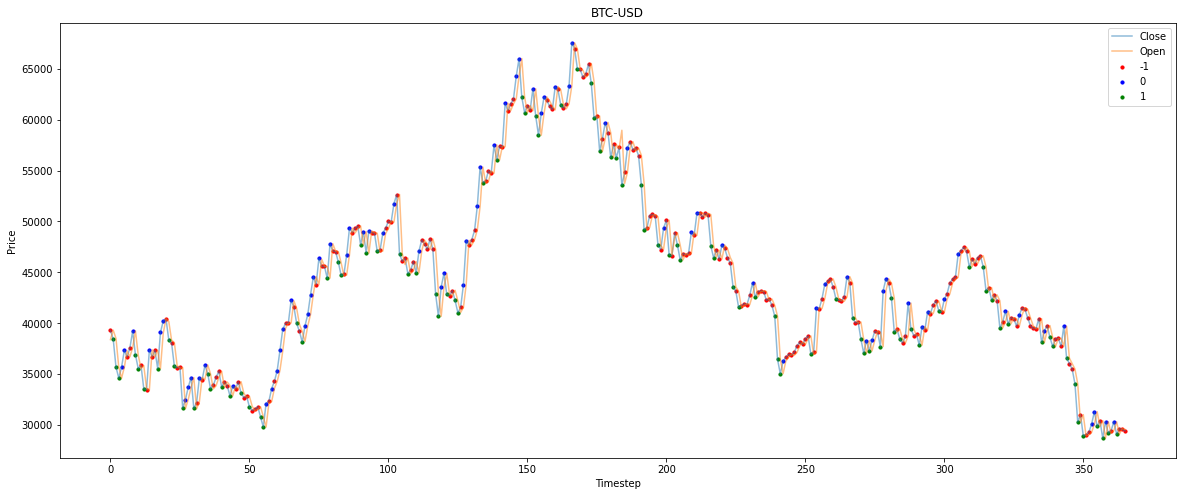

In [42]:
#now plot the result
cdict = {-1: 'red', 0: 'blue', 1: 'green'}
indx = np.array(range(len(btc['efficiency'])))
fig, ax = plt.subplots(figsize=(20,8))
for g in np.unique(btc['label']):
    ix = np.where(btc['label'] == g)
    ax.scatter(indx[ix], btc['Close'].iloc[ix], c = cdict[g], label = g, s = 10)
ax.plot(btc['Close'],alpha=0.5,label='Close')
ax.plot(btc['Open'],alpha=0.5,label='Open')
ax.set_ylabel('Price')
ax.set_xlabel('Timestep')
ax.set_title('BTC-USD')
ax.legend()
plt.show()

# Question 2

In [45]:
gold = pd.read_csv(FILE_PATH +'Gold-USD.csv')
oil = pd.read_csv(FILE_PATH +'Oil-USD.csv')

In [43]:
# Dates in the gold and oil dateset isn't in proper format
# define a function to fix it
def text_to_date(str):
    Months = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05', \
        'Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
    month,day,year = str.split()
    day = day.split(',')[0]
    month = Months[month]
    return datetime(year=int(year),day=int(day),month= int(month))

In [46]:
#apply the function to datasets
oil['Date']=oil['Date'].apply(text_to_date)
gold['Date']=gold['Date'].apply(text_to_date)

In [47]:
# remove stars from column names
oil.rename({'Close*':'Close','Adj Close**':'Adj Close'},axis=1,inplace=True)
gold.rename({'Close*':'Close','Adj Close**':'Adj Close'},axis=1,inplace=True)

In [48]:
#calculate the efficiency
oil['efficiency'] = (oil['Close'] - oil['Open']) / oil['Open']
gold['efficiency'] = (gold['Close'] - gold['Open']) / gold['Open']

In [49]:
#dates in btc have hyphens in between and are in string format
def remove_hyphen(str):
    year,month,day = str.split('-')
    return datetime(year=int(year),day=int(day),month= int(month))

In [50]:
#apply the function
btc['Date'] = btc['Date'].apply(remove_hyphen)

In [51]:
#btc has more rows than gold and oil (btc market never closes!)
#so merge all three datasets  to get rid of additional rows in btc and keep only the date and efficiency columns

efficiency = pd.merge(left=btc,right=oil,right_on='Date',left_on='Date')[['Date','efficiency_x','efficiency_y']]\
    .rename({'efficiency_x':'BTC','efficiency_y':'GOLD'},axis=1)
efficiency=pd.concat((efficiency,oil['efficiency']),axis=1).rename({'efficiency':'OIL'},axis=1)

In [52]:
efficiency

,Date,BTC,GOLD,OIL
0,2021-05-26,0.023483,0.002574,0.035143
1,2021-05-27,-0.022380,0.010429,-0.000544
2,2021-05-28,-0.072960,-0.009410,-0.005797
3,2021-06-01,-0.016326,0.015597,-0.002442
4,2021-06-02,0.023849,0.012355,0.015971
...,...,...,...,...
250,2022-05-20,-0.036633,0.015971,0.012355
251,2022-05-23,-0.039938,-0.002442,0.015597
252,2022-05-24,0.019053,-0.005797,-0.009410
253,2022-05-25,-0.003061,-0.000544,0.010429


In [53]:
#calculate the correlation between btc and gold and oil efficiency with 5 day lag difference
oil_corr = []
gold_corr = []
for i in range(-60,60,5):
    oil_corr.append((i,pearsonr(efficiency['OIL'],efficiency['BTC'].shift(periods=i,fill_value=0))[0]))
    gold_corr.append((i,pearsonr(efficiency['GOLD'],efficiency['BTC'].shift(periods=i,fill_value=0))[0]))
oil_corr = np.array(oil_corr)
gold_corr= np.array(gold_corr)

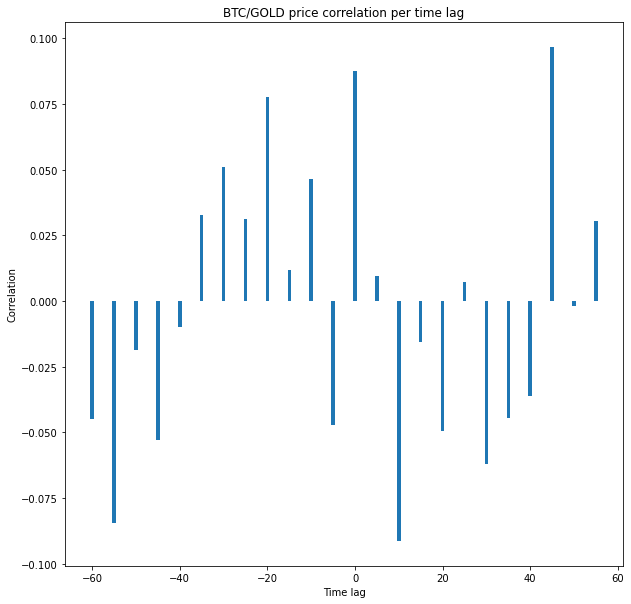

In [55]:
#plot the results
plt.figure(figsize=(10,10))
plt.title('BTC/GOLD price correlation per time lag')
plt.ylabel('Correlation')
plt.xlabel('Time lag')
plt.bar(gold_corr[:,0],gold_corr[:,1])
plt.show()

Inference: it seems that btc price has positive correlation in negative time lag (mostly -20 to -30 days) and negative correlation in positive time lags (mostly 10 to 15 day) and also there is a huge corolation with no time lag

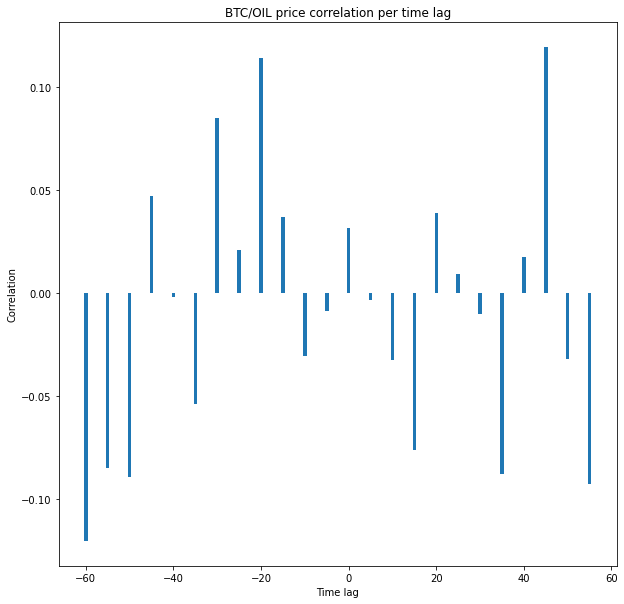

In [56]:
plt.figure(figsize=(10,10))
plt.title('BTC/OIL price correlation per time lag')
plt.ylabel('Correlation')
plt.xlabel('Time lag')
plt.bar(oil_corr[:,0],oil_corr[:,1])
plt.show()

Inference: it's kind  of similar to BTC/GOLD but it seems that correlations are weaker also there is no correlation in no time lag

# Question 3

In [66]:
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
import tensorflow as tf

In [57]:
# we don't need the Date and efficiency and label columns so we get rid of them
btc = btc.drop(labels=['Date','efficiency','label'],axis=1)

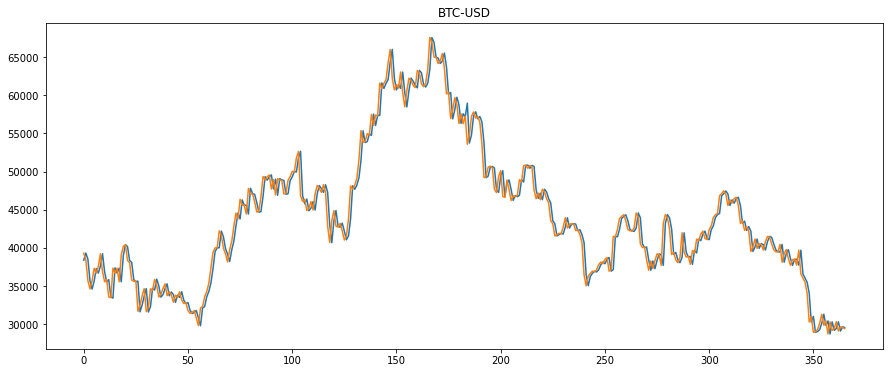

In [58]:
# plot the original data
plt.figure(figsize=(15,6))
plt.plot(btc['Open'])
plt.plot(btc['Close'])
plt.title('BTC-USD')
plt.show()

In [63]:
# in order to predict the timeseries we need a dataset with 4 day timelaps and close and open price as labels
def sliding_window(data,time_step):
  X = []
  Y = []
  for i in range(time_step, len(data)):
      X.append(data[i-time_step:i,])
      Y.append(data[i,[0,3]])
  X, Y = np.array(X), np.array(Y)
  return X, Y

In [64]:
#split the data into train and test
data_train = btc.iloc[:int(0.8 * btc.shape[0]),:]
data_test = btc.iloc[int(0.8 * btc.shape[0]):,:]

In [67]:
#normalize the train and test data separatly
data_train_scaled = MinMaxScaler().fit_transform(data_train)
#we also create a normalizer for open and close so it's easier to invert transform them later
train_close_scaler = MinMaxScaler().fit(data_train[['Open','Close']])
data_test_scaled = MinMaxScaler().fit_transform(data_test)
test_close_scaler = MinMaxScaler().fit(data_test[['Open','Close']])

In [68]:
#set the hyper parameters
batch_size = 1
epochs = 50
validation_split = 0.1
time_step = 4
input_shape= (time_step,6)
units= 10

In [69]:
#apply the sliding window to data
x_train,y_train = sliding_window(data_train_scaled,4)
x_test,y_test = sliding_window(data_test_scaled,4)

In [72]:
#create a LSTM neural network for predicting the open and close price
model = Sequential()
model.add(layers.LSTM(units = units, input_shape = input_shape,activation='tanh'))
model.add(layers.Dense(units =2))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
start = dt.datetime.now().replace(microsecond=0)
model_history = model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=validation_split)
end = dt.datetime .now().replace(microsecond=0)
model_time = end-start

Epoch 1/50
259/259 [==============================] - 6s 10ms/step - loss: 0.0366 - val_loss: 0.0069
Epoch 2/50
259/259 [==============================] - 1s 4ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 3/50
259/259 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 4/50
259/259 [==============================] - 1s 3ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 5/50
259/259 [==============================] - 1s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 6/50
259/259 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 7/50
259/259 [==============================] - 1s 3ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 8/50
259/259 [==============================] - 1s 4ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 9/50
259/259 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 10/50
259/259 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 0.002

In [83]:
#define a functino for plotting the results
def plot_result(trainY, testY, train_predict, test_predict,train_time,loss):
    actual = np.append(trainY[:,0], testY[:,0])
    predictions = np.append(train_predict[:,0], test_predict[:,0])
    rows = len(actual)
    fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
    plt.xlabel('TimeStep')
    ax[0].set_ylabel('Price')
    ax[0].set_title('Open Price Actual and Predicted Values, Training Time: {}, Total amount of Loss: {}'.format(train_time,loss))
    ax[0].plot(actual,label='Actual Price')
    ax[0].plot(predictions,label='Predicted Price')
    ax[0].axvline(x=len(trainY), color='r')
    ax[0].legend()
    actual = np.append(trainY[:,1], testY[:,1])
    predictions = np.append(train_predict[:,1], test_predict[:,1])
    ax[1].set_title('Close Price')
    ax[1].plot(actual,label='Actual Price')
    ax[1].plot(predictions,label='Predicted Price')
    ax[1].axvline(x=len(trainY), color='r')
    ax[1].set_ylabel('Price')
    ax[1].legend()

In [74]:
y_train_inverse = train_close_scaler.inverse_transform(y_train)
y_test_inverse = test_close_scaler.inverse_transform(y_test)

In [75]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)
model_loss = model.evaluate(x_test,y_test)
train_pred_inverse= train_close_scaler.inverse_transform(train_pred)
test_pred_inverse = test_close_scaler.inverse_transform(test_pred)

3/3 [==============================] - 1s 6ms/step - loss: 0.0023


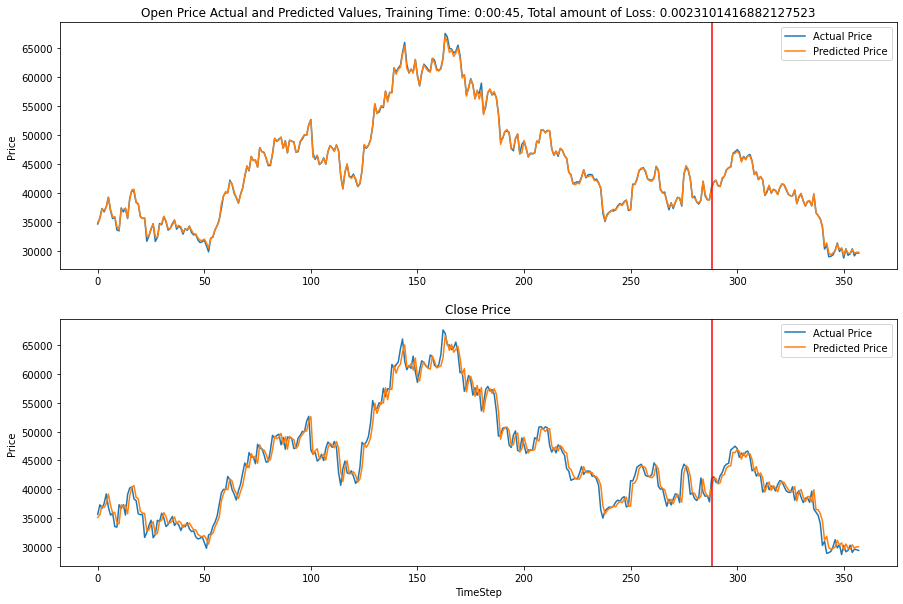

In [84]:
plot_result(y_train_inverse,y_test_inverse,train_pred_inverse,test_pred_inverse,model_time,model_loss)

In [79]:
# now we calculate the efficiency
predicted_efficieny = (test_pred_inverse[:,0] - test_pred_inverse[:,1]) / test_pred_inverse[:,0]

In [80]:
predicted_efficieny

array([ 7.0605855e-03,  3.4504011e-03,  4.8211408e-03,  5.7524312e-03,
       -1.9067724e-04,  4.5031691e-03,  6.9885338e-03,  6.1759637e-03,
        6.6889981e-03,  7.7205715e-03,  7.9884706e-03,  1.0255930e-02,
        7.0652729e-03,  3.9263405e-03,  2.2388964e-03, -2.6717104e-03,
        3.3482010e-03,  4.3624090e-03,  3.4844519e-03,  5.6423917e-03,
       -8.1438915e-04, -6.2102224e-03, -6.7849841e-04, -1.9754267e-04,
        6.0247323e-03,  1.8773591e-03, -5.1634088e-03,  1.1211638e-03,
        4.3919622e-03,  2.6301816e-04,  2.7222179e-03,  3.1270951e-03,
        1.9140163e-03,  6.6389218e-03,  5.9989383e-03,  3.7824144e-03,
       -2.3904743e-03, -3.2608046e-03, -1.5029220e-03,  1.0802720e-03,
        4.2433734e-03, -3.4805480e-03, -1.3724648e-03, -3.8229358e-05,
       -4.6652365e-03, -5.5061383e-03, -2.3861798e-03, -2.0450705e-03,
       -1.4991680e-03,  1.5306066e-03, -1.1464144e-02, -1.0717513e-02,
       -1.1064428e-02, -1.5006342e-02, -1.7233716e-02, -1.1392767e-02,
      